['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']
Points 

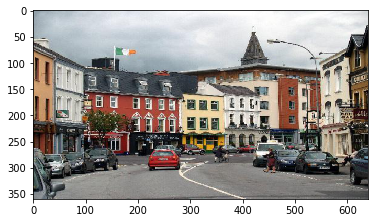

In [31]:
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
from scipy import misc
import csv
import numpy as np
from scipy import misc

%matplotlib inline

# the backgorunds
background_images = []
BACKGROUND_DIR = './backgrounds/'
BACKGROUND_X = 640
BACKGROUND_Y = 360



for fname in listdir(BACKGROUND_DIR):
    img = misc.imresize(misc.imread(BACKGROUND_DIR + fname), (BACKGROUND_Y, BACKGROUND_X))
    background_images.append(img)
    
plt.imshow(background_images[1])


# the imageset
df = pd.DataFrame()

PATH = 'GTSRB/Final_Training/Images'
for label_dir in listdir(PATH):
    try: label_dir.index('000')
    except ValueError: continue
    my_path = '{}/{}/'.format(PATH, label_dir)
    df_csv = pd.read_csv('{}/GT-{}.csv'.format(my_path, label_dir), sep=';')
    df_csv['Path'] = my_path
    df = pd.concat([df, df_csv])
    

label_names = []
with open('signnames.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        label_names.append(row[1])

del label_names[0]
class_id_set = range(len(label_names))        

print (label_names)
print ('Points in set:', len(df))


Filename                       00000_00000.ppm
Width                                       29
Height                                      29
Roi.X1                                       6
Roi.Y1                                       5
Roi.X2                                      24
Roi.Y2                                      24
ClassId                                     41
Path        GTSRB/Final_Training/Images/00041/
Name: 0, dtype: object


(array([  2.01580000e+04,   1.10050000e+04,   4.37200000e+03,
          1.93700000e+03,   1.01400000e+03,   4.31000000e+02,
          1.91000000e+02,   6.90000000e+01,   2.60000000e+01,
          6.00000000e+00]),
 array([  20. ,   38.5,   57. ,   75.5,   94. ,  112.5,  131. ,  149.5,
         168. ,  186.5,  205. ]),
 <a list of 10 Patch objects>)

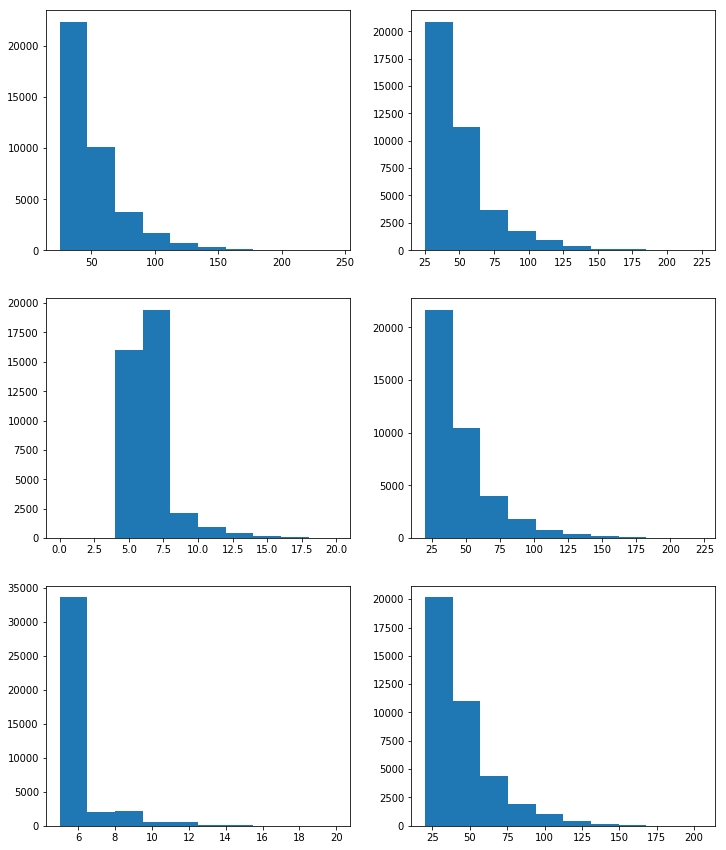

In [32]:
print (df.iloc[0])
plt.figure(figsize=(12,15))

plt.subplot(3,2,1)
plt.hist(df['Width'].values)
plt.subplot(3,2,2)
plt.hist(df['Height'].values)
plt.subplot(3,2,3)
plt.hist(df['Roi.X1'].values)
plt.subplot(3,2,4)
plt.hist(df['Roi.X2'].values)
plt.subplot(3,2,5)
plt.hist(df['Roi.Y1'].values)
plt.subplot(3,2,6)
plt.hist(df['Roi.Y2'].values)

In [33]:
## generating the training dataset
import random
from math import *
from skimage import exposure

# generating the traffic sign on backgound dataset
df_selected = df[df['Width'] > 50]
df_selected = df_selected.sample(frac=1)

n = 100

# X - list of the train images
X_list = []
#y1_list, y2_list, x1_list, x2_list =[], [], [], []
# x1, y1, x2, y2 ... list of the sign coords
Y_list = []

for i in range(n):
    sign_img = misc.imread(df_selected.iloc[i]['Path'] + df_selected.iloc[i]['Filename'])
    background = np.copy(background_images[i % len(background_images) ])
    
    sign_y, sign_x = sign_img.shape[0], sign_img.shape[1]
    pos_y1, pos_x1 = random.randint(0, BACKGROUND_Y - sign_y -1 ), random.randint(0, BACKGROUND_X - sign_x - 1)

    pos_y2 = pos_y1 + sign_y
    pos_x2 = pos_x1 + sign_x

    Y_list.append([pos_y1 + df_selected.iloc[i]['Roi.Y1'],
                  pos_x1 + df_selected.iloc[i]['Roi.X1'],
                  pos_y2 - (sign_y - df_selected.iloc[i]['Roi.Y2']),
                  pos_x2 - (sign_x - df_selected.iloc[i]['Roi.X2'])]
                 )
                  
        
    generated = background
    sign_img = np.zeros((sign_img.shape[0], sign_img.shape[1], 3))
                        
    generated[pos_y1 : pos_y2, pos_x1 : pos_x2, 0:3] = sign_img
    generated = exposure.equalize_hist(generated)
    
    X_list.append(generated)

X_list = np.array(X_list)
Y_list = np.array(Y_list)

    
    

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


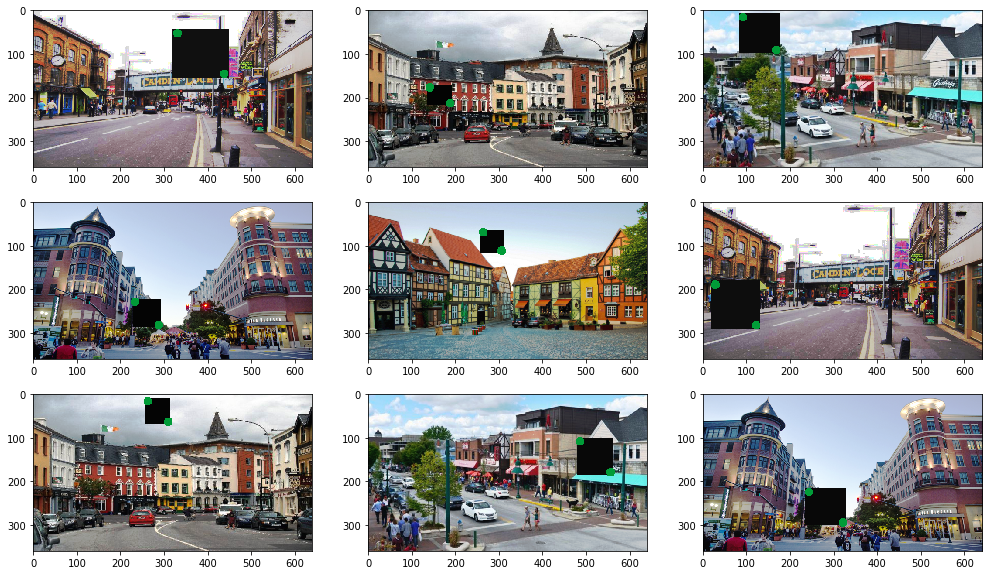

In [34]:
from skimage import draw
plt.figure(figsize=(17,10))
n = 3
m = 3
for j in range(n):
    for k in range(n):
        i = j * m + k
        plt.subplot(n, m, i+1)
        img = np.copy(X_list[i])

        rr, cc = draw.circle(Y_list[i][0], Y_list[i][1], 10)
        img[:,:,0][rr,cc] = 255
        img[:,:,1][rr,cc] = 100
        img[:,:,2][rr,cc] = 200

        rr, cc = draw.circle(Y_list[i][2], Y_list[i][3], 10)
        img[:,:,0][rr,cc] = 255
        img[:,:,1][rr,cc] = 100
        img[:,:,2][rr,cc] = 200
    
    
        plt.imshow(img)

In [35]:
TEST_PROP = 0.2

X_train = X_list[0:int(len(X_list) * (1-TEST_PROP))] 
X_test = X_list[int(len(X_list) * (1-TEST_PROP)):]

Y_train = Y_list[0:int(len(X_list) * (1-TEST_PROP))] 
Y_test = Y_list[int(len(X_list) * (1-TEST_PROP)):]

print ('X train/test', len(X_train), len(X_test))
print ('Y train/test', len(Y_train), len(Y_test))

print (np.min(X_list[0]), np.max(X_list[0]))


X train/test 80 20
Y train/test 80 20
0.0629470486111 1.0


In [36]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K

model = Sequential()
model.add(Convolution2D(6, 3, 3, input_shape=(BACKGROUND_Y, BACKGROUND_X, 3)))
model.add(MaxPooling2D((3,3)))
#model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Convolution2D(12, 3, 3, input_shape=(BACKGROUND_Y, BACKGROUND_X, 3)))
model.add(MaxPooling2D((3,3)))
#model.add(Dropout(0.2))
model.add(Activation('relu'))

#model.add(Convolution2D(24, 10, 10, input_shape=(BACKGROUND_Y, BACKGROUND_X, 3)))
#model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(1000))
model.add(Dense(100))
model.add(Dense(4))
print (model.output)

Tensor("add_71:0", shape=(?, 4), dtype=float32)


In [37]:
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

In [41]:
history = model.fit(X_train, Y_train, batch_size=20, nb_epoch=40,
          verbose=1, validation_data=(X_test, Y_test))


Train on 80 samples, validate on 20 samples
Epoch 1/40
80/80 [==============================] - 7s - loss: 43.9978 - acc: 0.8375 - val_loss: 94.8719 - val_acc: 0.7500
Epoch 2/40
80/80 [==============================] - 7s - loss: 39.4459 - acc: 0.8625 - val_loss: 92.2097 - val_acc: 0.7500
Epoch 3/40
80/80 [==============================] - 7s - loss: 40.0996 - acc: 0.8375 - val_loss: 87.8019 - val_acc: 0.7500

In [18]:
ev = model.evaluate(X_test, Y_test)
print (ev)

200/200 [==============================] - 11s    
[71432.579218750005, 0.755]


In [42]:
pr = model.predict(X_test)

[ 147.48112488  182.73297119  194.05502319  241.54017639]
[ 226.5708313   236.75817871  261.00341797  288.75485229]
[ 176.7033844   175.86720276  225.79632568  239.70614624]
[ 220.85780334  485.49456787  249.91571045  536.98937988]
[ 218.56680298  211.58500671  258.76370239  268.13330078]
[ 129.72383118  294.30786133  179.00021362  353.88360596]
[ 193.6444397   358.24362183  254.64971924  437.5111084 ]
[  74.15857697  265.84442139  116.59355927  321.29293823]
[ 200.65751648  226.21031189  233.80046082  276.84634399]
[ 166.15257263  307.02114868  211.37458801  370.46157837]
[ 238.86312866  374.42681885  297.21347046  445.41827393]
[ 200.89405823  158.10792542  240.21951294  212.18991089]


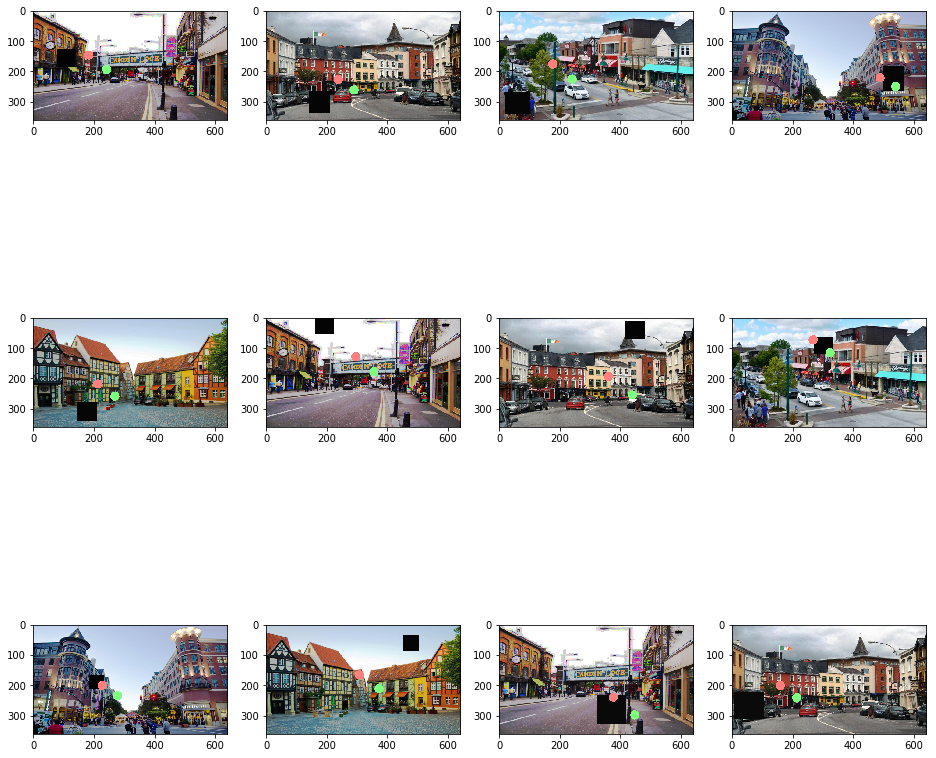

In [43]:
#with 80 epochs
n = 3
m = 4
plt.figure(figsize=(16,16))
for j in range(n):
    for k in range(m):
        i = j * m + k

        img = np.copy(X_test[i])
        y1, x1, y2, x2 = pr[i]
        rr, cc = draw.circle(y1, x1, 15)
        rr[rr > 359] = 359
        cc[cc > 639] = 639
        rr[rr < 0] = 0
        cc[cc < 0] = 0

        img[:,:,0][rr, cc] = 1
        img[:,:,1][rr, cc] = 0.5
        img[:,:,2][rr, cc] = 0.5

        rr, cc = draw.circle(y2, x2, 15)
        rr[rr > 359] = 359
        cc[cc > 639] = 639
        rr[rr < 0] = 0
        cc[cc < 0] = 0

        img[:,:,0][rr, cc] = 0.5
        img[:,:,1][rr, cc] = 1
        img[:,:,2][rr, cc] = 0.5

        plt.subplot(n, m, i+1)
        plt.imshow(img)
        print (pr[i])